# Evaluation of XGBoost Model

## Setup

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

import sys
sys.path.append("..")

import starcraft_predictor as scp

In [2]:
pd.options.mode.chained_assignment = None

## Model Diagnostics

In [3]:
scp.starcraft_model.model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2709,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.75,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [4]:
scp.starcraft_model.model.best_ntree_limit

38

In [5]:
def plot_feature_importance(model):
    
    feat_imp_df = pd.DataFrame({
        "features": model.get_booster().feature_names,
        "importance": model.feature_importances_,
    })
    
    feat_imp_df = feat_imp_df.sort_values("importance", ascending=False)
    
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.barplot(y=feat_imp_df["features"], x=feat_imp_df["importance"], color="blue", alpha=0.5)
    plt.title("Feature Importance")
    plt.show()

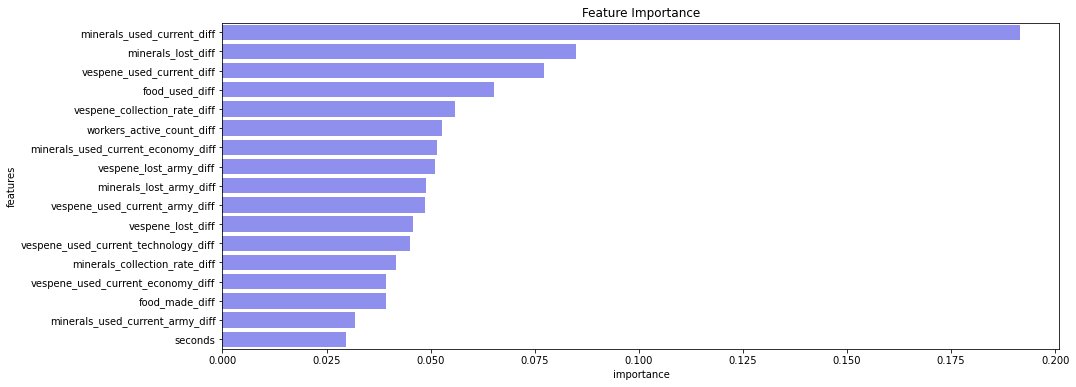

In [6]:
plot_feature_importance(scp.starcraft_model.model)

## Evaluation Metrics

Evaluation metrics can be expected to improve as game time grows. Here we will look at the AUC per minute, rather than for the full dataset. Given a game can run any number of minutes, a hard cap will be set at 20 minutes. Anything over 20 minutes will be bucketed in with the last window.

In [7]:
# load local data used to train the model
transformed_data = pd.read_csv("C:/Users/Ned/OneDrive/Documents/Python Projects/data/transformed_data.csv")
train_data = transformed_data[transformed_data["sample"] == "train"]
test_data = transformed_data[transformed_data["sample"] == "test"]

In [8]:
train_data["predictions"] = scp.starcraft_model.predict(train_data)
test_data["predictions"] = scp.starcraft_model.predict(test_data)

In [9]:
# get train AUCs
train_aucs = []
for i in range(20):

    lower_bound = i*60
    upper_bound = (i+1)*60
    
    data_subset = train_data[
        (train_data["seconds"] >= lower_bound) & (train_data["seconds"] < upper_bound)
    ]

    auc = roc_auc_score(data_subset["winner"], data_subset["predictions"])

    train_aucs.append(auc)

In [10]:
# get test AUCs
test_aucs = []
for i in range(20):

    lower_bound = i*60
    upper_bound = (i+1)*60
    
    data_subset = test_data[
        (test_data["seconds"] >= lower_bound) & (test_data["seconds"] < upper_bound)
    ]

    auc = roc_auc_score(data_subset["winner"], data_subset["predictions"])

    test_aucs.append(auc)

In [11]:
plotting_df = pd.DataFrame(
    {
        "train": train_aucs,
        "test": test_aucs,
    },
    index=np.arange(1, 21),
)

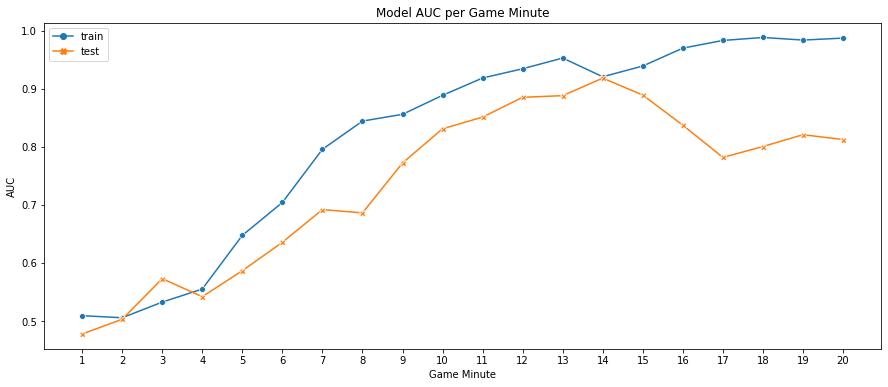

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=plotting_df, markers=True, dashes=False)
plt.xticks(np.arange(1, 21))
plt.title("Model AUC per Game Minute")
plt.ylabel("AUC")
plt.xlabel("Game Minute")
plt.show()